In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from torch.optim import lr_scheduler
import time
import copy

In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
os.chdir("/content/gdrive/My Drive/Colab Notebooks")

In [ ]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import ConcatDataset, random_split, SubsetRandomSampler, WeightedRandomSampler

# Data preprocessing


In [ ]:
#從imagenet的圖像中 抽樣計算出來的
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


In [ ]:
#常見手法：先將圖片放大一點點，在進行切割，可以有效增加資料的多樣性
data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomCrop((224, 224)),
        transforms.RandomAffine(degrees = 0, shear=10, scale=(0.8,1.2)), #進行縮放 shear（錯切） 
        transforms.ToTensor(),
        normalize
    ]),
    'test':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

In [ ]:
input_path = '/content/gdrive/My Drive/Colab Notebooks/data/'

In [ ]:
image_datasets = {
    'train': 
    datasets.ImageFolder(input_path + 'train', data_transforms['train']),
    'validation': 
    datasets.ImageFolder(input_path + 'train', data_transforms['test']),
    'test': 
    datasets.ImageFolder(input_path + 'test', data_transforms['test'])
}

In [ ]:
batch_size = 4
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(image_datasets['train'])
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(image_datasets['validation'], batch_size=batch_size,
                                                sampler=valid_sampler)

In [ ]:
test_loaders = torch.utils.data.DataLoader(image_datasets['test'],
                                batch_size=16,
                                shuffle=False,
                                num_workers=4)  

In [ ]:
dataloaders = {
    'train':
    train_loader,
    'validation':
    validation_loader,
    'test':
    test_loaders
}

In [ ]:
dataset_sizes = {x: len(dataloaders[x])*4 for x in ['train', 'validation']}
class_names = ["COVID-19","NORMAL","PNEUMONIA"]

In [ ]:
image_datasets['train']

Dataset ImageFolder
    Number of datapoints: 539
    Root location: /content/gdrive/My Drive/Colab Notebooks/data/train
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=PIL.Image.BILINEAR)
               RandomCrop(size=(224, 224), padding=None)
               RandomAffine(degrees=(0, 0), scale=(0.8, 1.2), shear=(-10, 10))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
class_names 

['COVID-19', 'NORMAL', 'PNEUMONIA']

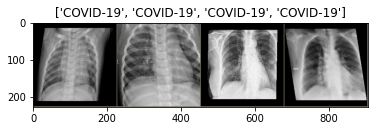

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.1)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Transfer learning
(凍結Resnet50的所有權重）

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

建立模型，會回傳出訓練過程中的最後一個epoch、validaiton accuracy最高和validation loss最低的模型

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts_acc = copy.deepcopy(model.state_dict())
    best_model_wts_loss = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 1.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) #'_' means ignore unneeded tensor above
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step() #更新模型參數
 
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step() #學習率更新

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts_acc = copy.deepcopy(model.state_dict())
            
            if phase == 'validation' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts_loss = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model_best_acc = copy.deepcopy(model)
    model_best_loss = copy.deepcopy(model)
    # load best model weights
    model_best_acc.load_state_dict(best_model_wts_acc)
    model_best_loss.load_state_dict(best_model_wts_loss)


    return model, model_best_acc, model_best_loss, best_acc

## Visualization

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['validation']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1) #找出分數最高對應的類別

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Note: 
1. loss function = cross entropy時 y不用轉換成one hot encoding 因為他在計算loss時會自動轉換
2. 根據https://reurl.cc/1xMLK9 ，訓練過程中，每個epoch都會放入新的資料（都沒看過的） i.e. 資料的總筆數 = 原本資料數*epoch

In [ ]:
def build_transfer_learning_model():
    model_ft = models.densenet121(pretrained=True)
    for layer in model_ft.parameters():
        layer.requires_grad = False
    num_ftrs = model_ft.fc.in_features
    # Here the size of each output sample is set to 3.
    # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
    model_ft.fc = nn.Sequential(
        nn.Linear(num_ftrs, 128),
        nn.ReLU(inplace=True),
        nn.Linear(128, 3))

    model_ft = model_ft.to(device)

    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

    return model_ft, criterion, optimizer_ft, exp_lr_scheduler

In [ ]:
model_ft, criterion, optimizer_ft, exp_lr_scheduler = build_transfer_learning_model()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth


AttributeError: ignored

## 觀察模型架構

In [ ]:
!pip install hiddenlayer

In [ ]:
from torchsummary import summary
import hiddenlayer as hl

In [ ]:
summary(model_ft, (3, 224, 224))

In [ ]:
hl.build_graph(model_ft, torch.zeros([4, 3, 224, 224]).cuda())

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs = 50)

In [ ]:
visualize_model(model_ft)

In [ ]:
def predict(model, batch_size):
    tmp = 0.0
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            #print("batch %d" %i)
            for j in range(inputs.size()[0]):
                #print("{} pred label:{}, true label:{}".format(len(preds), class_names[preds[j]], class_names[labels[j]]))
                if class_names[preds[j]] == class_names[labels[j]]:
                    tmp += 1
    print('accuracy is {}'.format(tmp/(len(dataloaders['test'])*batch_size)))

In [ ]:
predict(model_ft)

In [ ]:
predict(model_ft_best_acc)

In [ ]:
predict(model_ft_best_loss)

# Cross Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
model = []
model_best_acc = []
model_best_loss = []
acc = []
sfolders = StratifiedKFold() #等權重建立cross validation的子集
train_indices = []
val_indices = []
batch_size = 16
indices = list(range(dataset_size))
for train_index, val_index in sfolders.split(indices, image_datasets['train'].targets):
    train_indices.append(list(train_index))
    val_indices.append(list(val_index))

for i in range(5):
    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices[i])
    valid_sampler = SubsetRandomSampler(val_indices[i])

    train_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size,
                                            sampler=train_sampler)
    validation_loader = torch.utils.data.DataLoader(image_datasets['validation'], batch_size=batch_size, shuffle=False,
                                                    sampler=valid_sampler)

    test_loaders = torch.utils.data.DataLoader(image_datasets['test'],
                                    batch_size=batch_size,
                                    shuffle=False,
                                    num_workers=4)

    dataloaders = {
        'train':
        train_loader,
        'validation':
        validation_loader,
        'test':
        test_loaders
    }

    dataset_sizes = {x: len(dataloaders[x])*batch_size for x in ['train', 'validation']}
    print(dataset_sizes)
    class_names = image_datasets['train'].classes

    print('{}/5 folds'.format(i+1))

    model_ft, criterion, optimizer_ft, exp_lr_scheduler = build_transfer_learning_model()

    model_ft, model_ft_best_acc, model_ft_best_loss, best_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs = 50)
    model.append(model_ft)
    model_best_acc.append(model_ft_best_acc)
    model_best_loss.append(model_ft_best_loss)
    acc.append(best_acc)
    torch.save(model_ft, 'model' + str(i + 1) + '.pth')
    torch.save(model_ft_best_acc, 'model_best_acc' + str(i + 1) + '.pth')
    torch.save(model_ft_best_loss, 'model_best_loss' + str(i + 1) + '.pth')

In [ ]:
for i in range(5):
    print('{}/5 folds'.format(i+1))
    predict(model[i])
    predict(model_best_acc[i])
    predict(model_best_loss[i])

In [ ]:
mean = torch.mean(torch.stack(acc))
mean

In [ ]:
checkpoint = torch.load('/content/gdrive/My Drive/Colab Notebooks/m-25012018-123527.pth.tar',map_location=torch.device('cpu'))
net = checkpoint['model']

# Final model

In [ ]:
Dataloader = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size,
                                            shuffle = True, num_workers = 4), 
    'test':
    torch.utils.data.DataLoader(image_datasets['test'],
                                    batch_size=batch_size,
                                    shuffle=False,
                                    num_workers=4)
}

In [ ]:
dataset_sizes = {x: len(dataloaders[x])*batch_size for x in ['train', 'test']}
class_names = image_datasets['train'].classes

In [ ]:
model_final, criterion, optimizer_ft, exp_lr_scheduler = build_transfer_learning_model()

In [ ]:
def train_model_final(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts_acc = copy.deepcopy(model.state_dict())
    best_model_wts_loss = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 1.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) #'_' means ignore unneeded tensor above
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step() #更新模型參數
 
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step() #學習率更新

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test'' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts_acc = copy.deepcopy(model.state_dict())
            
            if phase == 'test' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts_loss = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model_best_acc = copy.deepcopy(model)
    model_best_loss = copy.deepcopy(model)
    # load best model weights
    model_best_acc.load_state_dict(best_model_wts_acc)
    model_best_loss.load_state_dict(best_model_wts_loss)


    return model_best_acc, model_best_loss, best_acc

In [ ]:
model_final_acc, model_final_loss, accuracy = train_model_final(model_final, criterion, optimizer_ft, exp_lr_scheduler, num_epochs = 100)

In [ ]:
accuracy